In [1]:
from datetime import datetime
print("This notebook is to test and demonstrate PSF correction, parameter estimation,\n"
	  "and line fitting. Last manual datestamp 030725, last automatic datestamp:",datetime.now())

This notebook is to test and demonstrate PSF correction, parameter estimation,
and line fitting. Last manual datestamp 030725, last automatic datestamp: 2025-03-12 16:32:27.392312


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import importlib, time, copy, os, sys, numpy as np, astropy.units as u
np.set_printoptions(linewidth=160)

from astropy.io import fits; import matplotlib.pyplot as plt; from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 18,'figure.figsize':[15,12],'image.origin':'lower'}) # Make the fonts big enough for papers

base_path = '../'
sys.path.append(base_path+'linefit_modules/')
from util import get_mask_errs, get_spice_err
from skew_correction import skew_correct, deskew_linefit_window, full_correction
from skew_parameter_search import search_shifts, shift_holder, refine_points, search_spice_window
from linefit_leastsquares import lsq_fitter, lsq_fitter
from linefit_storage import linefits

from linefit_leastsquares import check_for_waves

/tmp/ipykernel_565077/3282514482.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [3]:
spicefile = 'solo_L2_spice-n-ras_20220307T030536_V22_100663723-000.fits'
searchfile_path = os.path.join('../data',spicefile)

outfile = spicefile[:-5]+'psfcorrected_linefits.fits'
outfile_path = os.path.join('../data',outfile)

win_name = 'C III 977 (Merged)'
win_name2 = 'S V 786 / O IV 787 - Extend'

In [4]:
# Search for the best shift in first window:
# Results will be placed in ../spice_shift_vars/save with figures in ../spice_shift_var/figs
shift_vars = search_spice_window(searchfile_path, win_name, nthreads=32)

Found the following lines in C III 977 (Merged): ['C III 977']
20220307T030536.112_C_III_977_(Merged)


In [5]:
# Search for the best shift in second window:
shift_vars2 = search_spice_window(searchfile_path, win_name2, nthreads=32)

Found the following lines in S V 786 / O IV 787 - Extend: ['S V 786', 'O IV 787']


/data/jplowman/projects/spice-line-fitting/notebooks/../linefit_modules/util.py:92: RuntimeWarning: All-NaN slice encountered
  spice_dat = copy.deepcopy(spice_dat_in) - np.nanmean(np.nanmin(spice_dat_in,axis=0))
/data/jplowman/projects/spice-line-fitting/notebooks/../linefit_modules/util.py:94: RuntimeWarning: Mean of empty slice
  signal = np.nanmean(signal_cube,axis=(0,2))
/data/jplowman/projects/spice-line-fitting/notebooks/../linefit_modules/util.py:122: RuntimeWarning: Mean of empty slice
  signal_img = np.clip(np.nanmean(snr_cube,axis=2),0,None)


[ 1.667     -0.667      1.3210513]
20220307T030536.112_S_V_786___O_IV_787_Extend


In [6]:
# Print the best shift:
best_xshift, best_yshift = shift_vars.best_shifts()
print('Best correction parameters in ', win_name,' window:', best_xshift, best_yshift)
best_xshift2, best_yshift2 = shift_vars2.best_shifts()
print('Best correction parameters in ', win_name2,' window:', best_xshift2,best_yshift2)

Best correction parameters in  C III 977 (Merged)  window: 2.0 -1.667
Best correction parameters in  S V 786 / O IV 787 - Extend  window: 1.667 -2.667


In [7]:
hdul=fits.open(searchfile_path)
hdul.info()
dat,hdr = hdul[win_name].data[0].T, hdul[win_name].header
dat2,hdr2 = hdul[win_name2].data[0].T, hdul[win_name2].header
hdul.close()

Filename: ../data/solo_L2_spice-n-ras_20220307T030536_V22_100663723-000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Mg IX 706 - Peak    1 PrimaryHDU     418   (128, 834, 50, 1)   float32   
  1  O II 718 - Peak    1 ImageHDU       417   (128, 834, 50, 1)   float32   
  2  Ne VIII 770 / Mg VIII 772 (Merged)    1 ImageHDU       424   (128, 834, 66, 1)   float32   
  3  S V 786 / O IV 787 - Extend    1 ImageHDU       426   (128, 834, 58, 1)   float32   
  4  Ly Gamma 972 - Peak    1 ImageHDU       417   (128, 834, 36, 1)   float32   
  5  C III 977 (Merged)    1 ImageHDU       426   (128, 834, 42, 1)   float32   
  6  O VI 1032 - Peak    1 ImageHDU       417   (128, 834, 34, 1)   float32   
  7  VARIABLE_KEYWORDS    1 BinTableHDU    398   1R x 28C   [128D, 128I, 128I, 128I, 128I, 128I, 128E, 128E, 128E, 128E, 4I, 4I, 4I, 4I, 4J, 4J, 4J, 4J, 2944A, 128D, 128D, 50D, 50D, 66D, 58D, 36D, 42D, 34D]   
  8  WCSDVARR      1 ImageHDU        28   (128,)   float64   
  9

In [8]:
# Make corrected data; fit spectral lines etc:
best_correction_results = full_correction(dat, hdr, best_xshift, best_yshift, nthreads=32)

In [9]:
# Do the same for the other window:
best_correction_results2 = full_correction(dat2, hdr2, best_xshift2, best_yshift2, nthreads=32)

In [10]:
# Combine the fits to the two lines into one linefits structure
output_linefits = linefits()
output_linefits.update(best_correction_results['linefits'])
output_linefits.update(best_correction_results2['linefits'])

In [11]:
# Output is an iterable nested dictionary-like_structure with the ability to
# save to and load from fits files. Output includes values, errors, and meta
# data for each fitted parameter for the window, along with goodness of fit:
print('Output linefits contains fits for the following windows:', list(output_linefits.keys()))
print(list(output_linefits.keys())[0],' contains ',list(output_linefits[0].keys()))
print(list(output_linefits.keys())[1],' contains ',list(output_linefits[1].keys()))

# Save the linefits to a fits file (fits 'card is too long error' still needs addressing):
output_linefits.save(outfile_path)

Output linefits contains fits for the following windows: ['C III 977 (Merged)', 'S V 786 / O IV 787 - Extend']
C III 977 (Merged)  contains  ['C III 977', 'BACKGROUND', 'CHI2']
S V 786 / O IV 787 - Extend  contains  ['S V 786', 'O IV 787', 'BACKGROUND', 'CHI2']


[Text(0.5, 1.0, 'Doppler; best xshift, yshift=2.0,-1.667')]

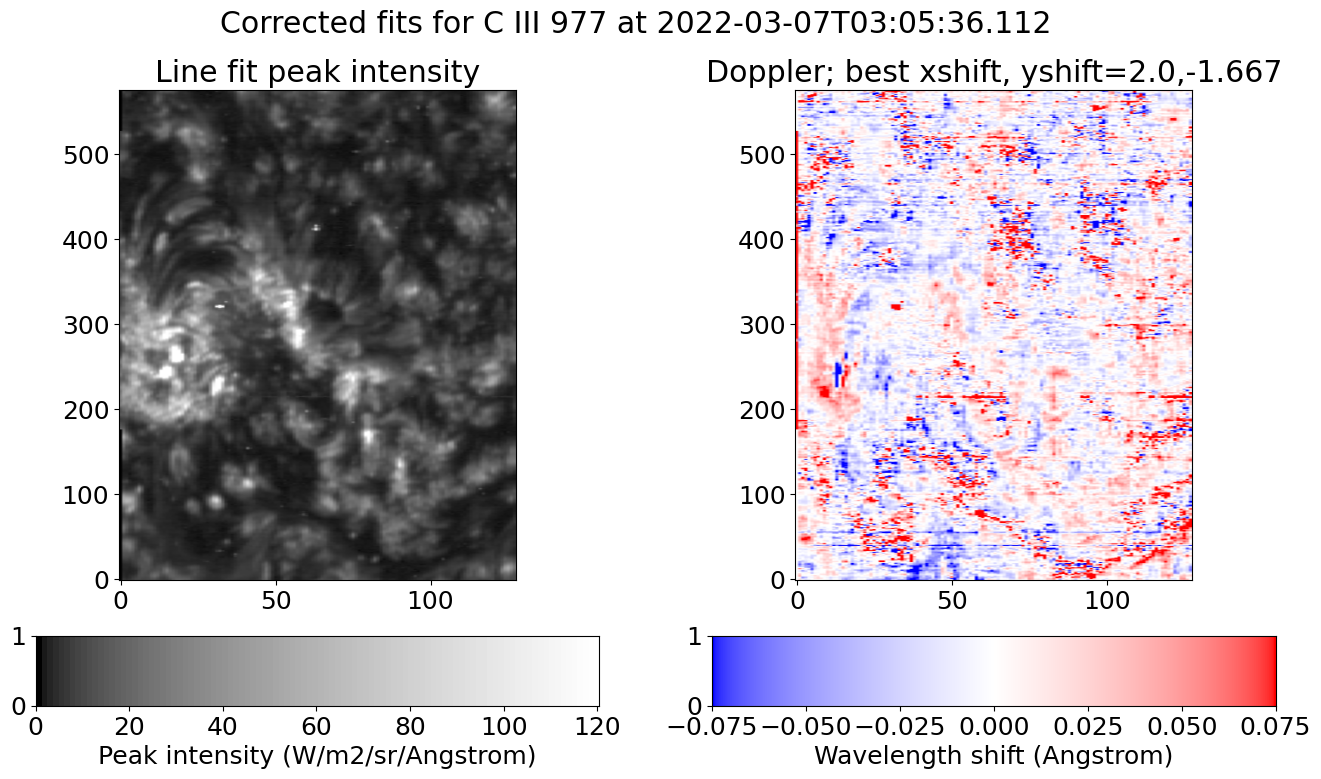

In [12]:
# Do some plots:
from plotting_modules import doppler_plot, amplitude_plot

plt_linefits = best_correction_results['linefits']
ymin,ymax = best_correction_results['ymin'],best_correction_results['ymax']
line_name = list(plt_linefits[0].keys())[0]
date = plt_linefits[0][0]['amplitudes'].meta['DATE-OBS']

fig=plt.figure(figsize=[16,8])
gs = GridSpec(nrows=2,ncols=2,width_ratios=[1,1],height_ratios=[7,1])
cbaxes = [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])]
axes = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])]

plt.suptitle('Corrected fits for '+line_name+' at '+date)
amplitude_plot(plt_linefits[0][0],axis=axes[0], cbaxis=cbaxes[0], ymin=ymin, ymax=ymax)
doppler_plot(plt_linefits[0][0],axis=axes[1], cbaxis=cbaxes[1], doppmin=-0.075, doppmax=0.075, ymin=ymin,ymax=ymax)
axes[1].set(title='Doppler; best xshift, yshift='+str(best_xshift)+','+str(best_yshift))

[Text(0.5, 1.0, 'Doppler; best xshift, yshift=1.667,-2.667')]

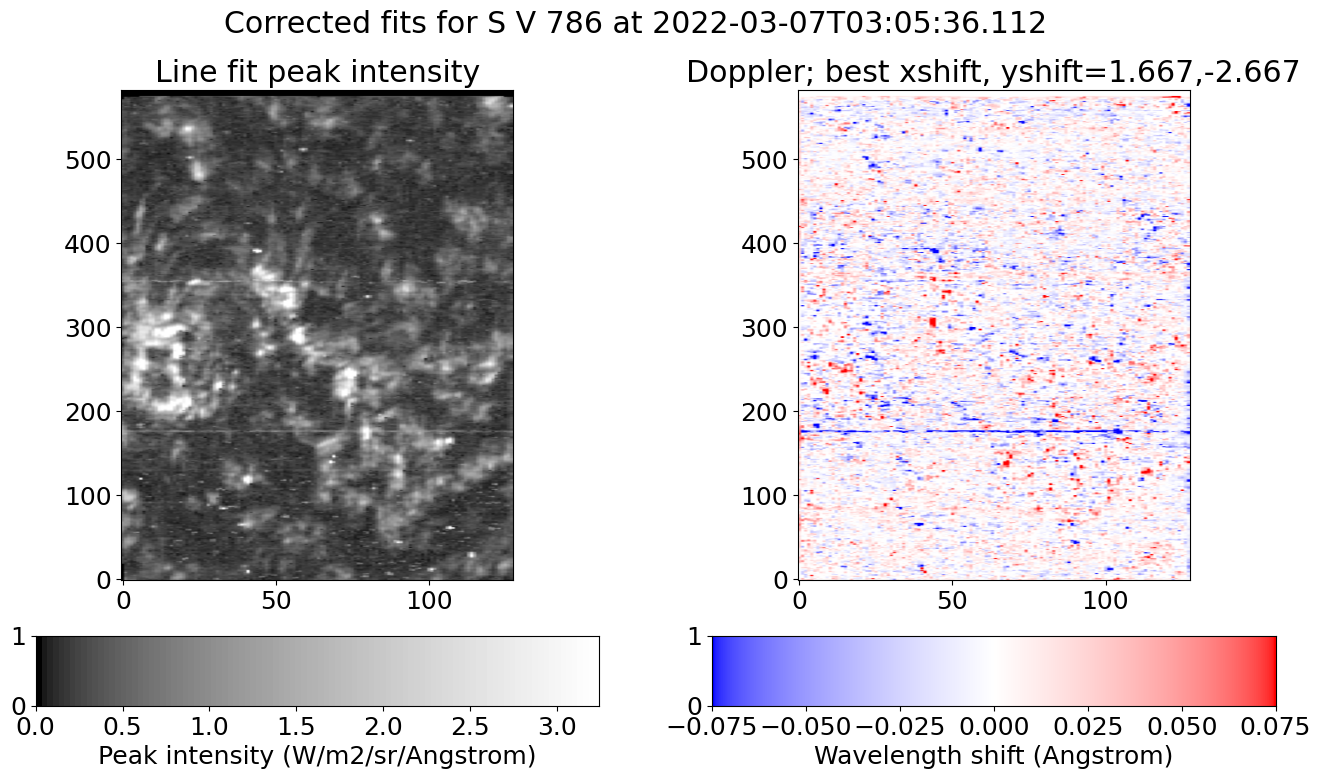

In [13]:
# Show results from the other window:
plt_linefits = best_correction_results2['linefits']
ymin,ymax = best_correction_results2['ymin'],best_correction_results['ymax']
line_name = list(plt_linefits[0].keys())[0]
date = plt_linefits[0][0]['amplitudes'].meta['DATE-OBS']

fig=plt.figure(figsize=[16,8])
gs = GridSpec(nrows=2,ncols=2,width_ratios=[1,1],height_ratios=[7,1])
cbaxes = [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])]
axes = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])]

plt.suptitle('Corrected fits for '+line_name+' at '+date)
amplitude_plot(plt_linefits[0][0],axis=axes[0], cbaxis=cbaxes[0], ymin=ymin, ymax=ymax)
doppler_plot(plt_linefits[0][0],axis=axes[1], cbaxis=cbaxes[1], doppmin=-0.075, doppmax=0.075, ymin=ymin,ymax=ymax)
axes[1].set(title='Doppler; best xshift, yshift='+str(best_xshift2)+','+str(best_yshift2))

In [14]:
# Do some more fits at representative xshift and yshift for illustrative purposes:
correction_example_results = []
correction_example_shifts = []
for i in range(0,3):
    for j in range(0,3):
        xshift, yshift = 2*i-2, 2*j-2
        print('Doing example correction with',xshift,yshift)
        correction_example_shifts.append([xshift,yshift])
        correction_example_results.append(full_correction(dat,hdr,xshift,yshift, nthreads=32))

Doing example correction with -2 -2
Doing example correction with -2 0
Doing example correction with -2 2
Doing example correction with 0 -2
Doing example correction with 0 0
Doing example correction with 0 2
Doing example correction with 2 -2
Doing example correction with 2 0
Doing example correction with 2 2


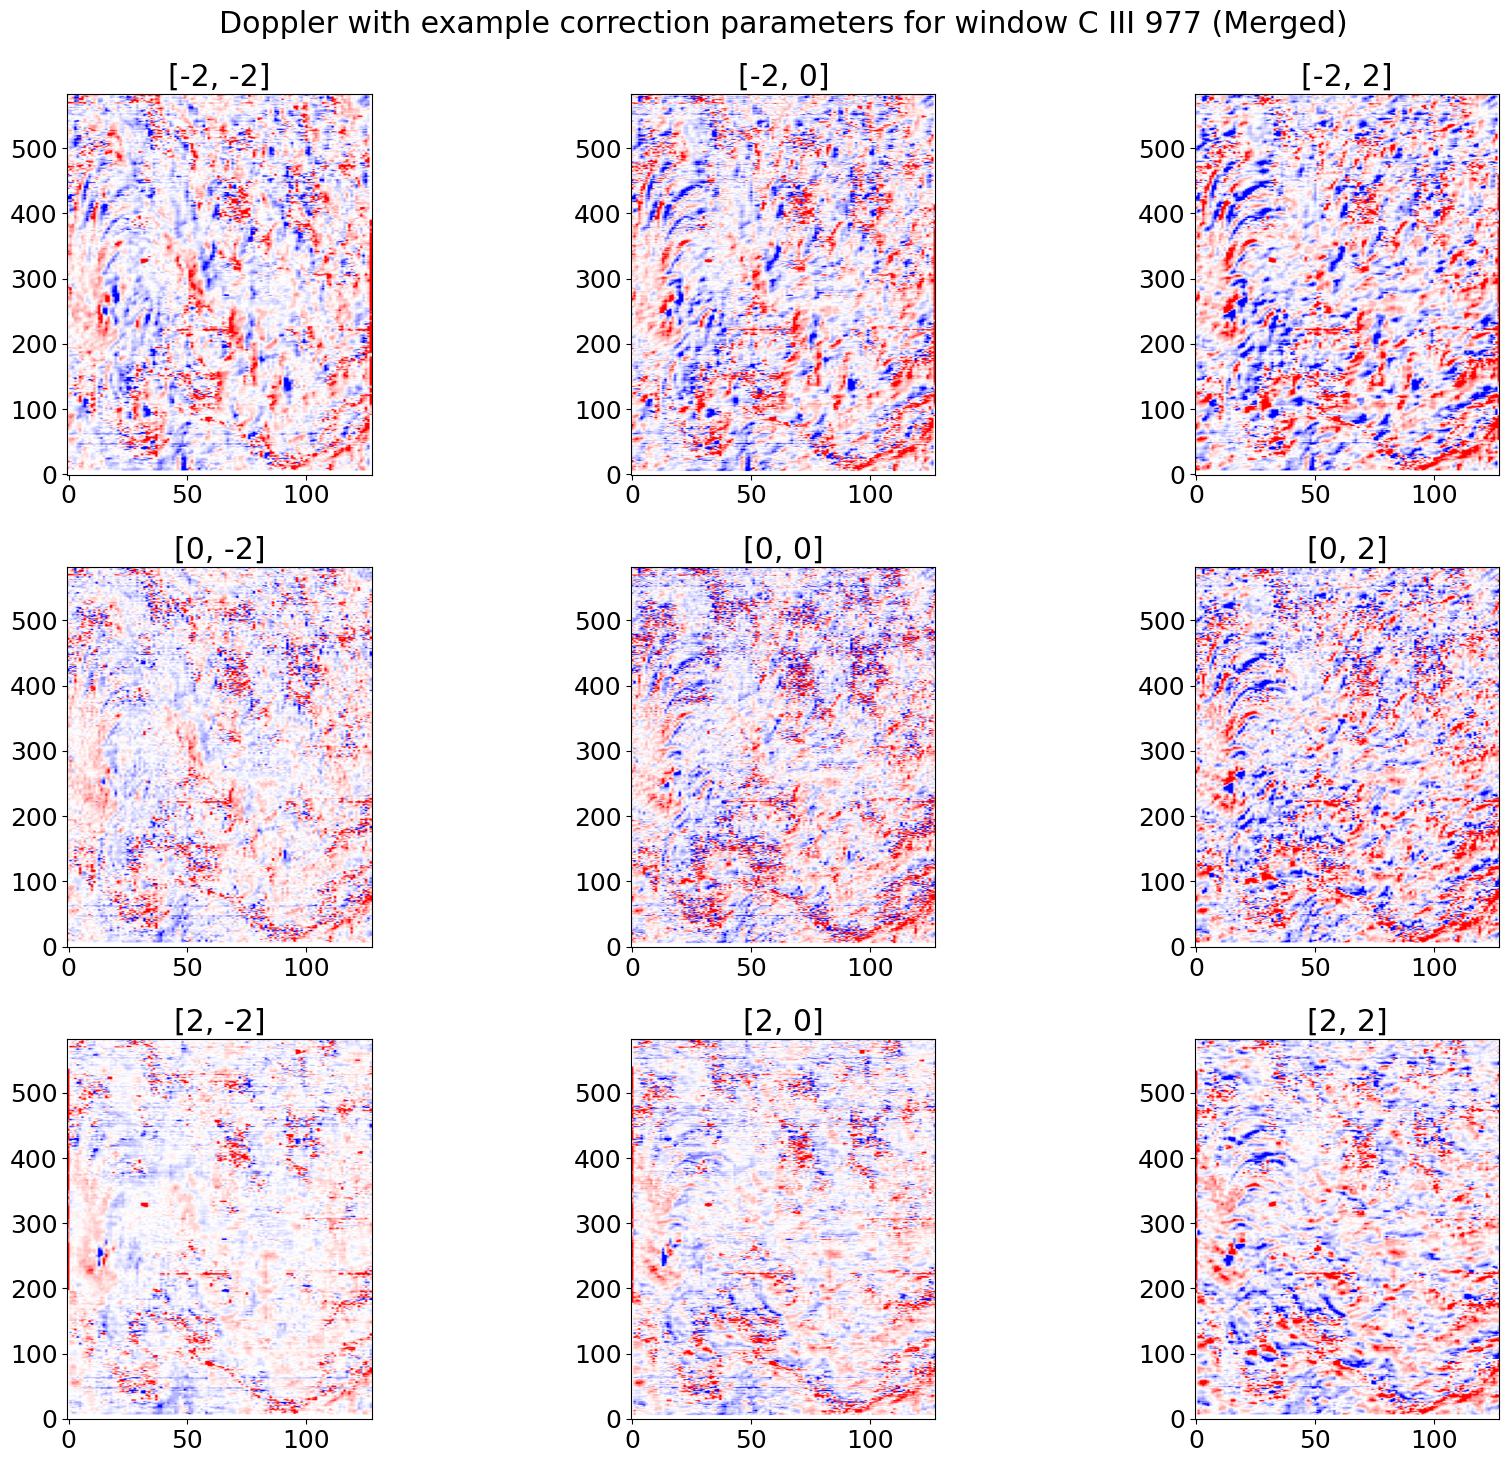

In [15]:
fig = plt.figure(figsize=[18,15])
plt.suptitle('Doppler with example correction parameters for window '+win_name)
gs = GridSpec(3, 3)
gs.tight_layout(fig)
axes=[]
for i in range(0,3):
    for j in range(0,3):
        axes.append(fig.add_subplot(gs[i,j]))
        doppler_plot(correction_example_results[i*3+j]['linefits'][0][0],axis=axes[-1],ymin=ymin,ymax=ymax)
        axes[-1].set(title=correction_example_shifts[i*3+j])
plt.tight_layout()